# 데이터 전처리 성능 비교

## data1

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor


def data1_prepro(df1=None, train=False, onehot=True):
    '''
    data1 전처리 함수.

    args:
        train : 학습용으로 전처리할것인지
        onehot : 원핫인코딩 할것인지 타겟인코딩 할것인지 (False=타겟인코딩)
    
    returns:
        X_train, X_test, y_train, y_test : train=True인경우
        X : train=False인 경우
    '''
    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')
    te = TargetEncoder(target_type='continuous')
    te.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')

    # 컬럼 변환기2 : Sex te, 나머지 표준화
    data1_ct_te = make_column_transformer(
        (te, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_te.set_output(transform='pandas')

    if 'Rings' in df1:
        X = df1.drop(columns='Rings')   
        y = df1.Rings
    else:
        X = df1

    if train:
        # test비율 20%로
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
        if onehot:
            X_train = data1_ct_ohe.fit_transform(X_train)
            X_test = data1_ct_ohe.transform(X_test)
        else:
            X_train = data1_ct_te.fit_transform(X_train, y_train)
            X_test = data1_ct_te.transform(X_test)
        return X_train, X_test, y_train, y_test
    else:
        return X
    

X_train, X_test, y_train, y_test = data1_prepro(train=True)
X_train_te, X_test_te, y_train_te, y_test_te = data1_prepro(train=True, onehot=False)

# model = XGBRegressor(n_estimators=500,
#                      objective='reg:squarederror',
#                      booster='gbtree',
#                      max_depth=8,
#                      learning_rate=0.01,
#                      tree_method='gpu_hist',
#                      gpu_id=0,
#                      eval_metric='rmse',
#                      early_stopping_rounds=20,
#                      random_state=42)

# model2 = XGBRegressor(n_estimators=500,
#                      objective='reg:squarederror',
#                      booster='gbtree',
#                      max_depth=8,
#                      learning_rate=0.01,
#                      tree_method='gpu_hist',
#                      gpu_id=0,
#                      eval_metric='rmse',
#                      early_stopping_rounds=20,
#                      random_state=42)

# model.fit(X_train, y_train,
#           eval_set=[(X_test, y_test)],
#           verbose=False)

# model2.fit(X_train_te, y_train_te,
#           eval_set=[(X_test_te, y_test_te)],
#           verbose=False)
# ''

XGBoostError: [14:00:10] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017f0059f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017f0eb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000017f0e63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000017f1061e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000017f01e86c XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001014ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001014a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x000000010148c140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001014864a4 PyCFuncPtr_call + 228



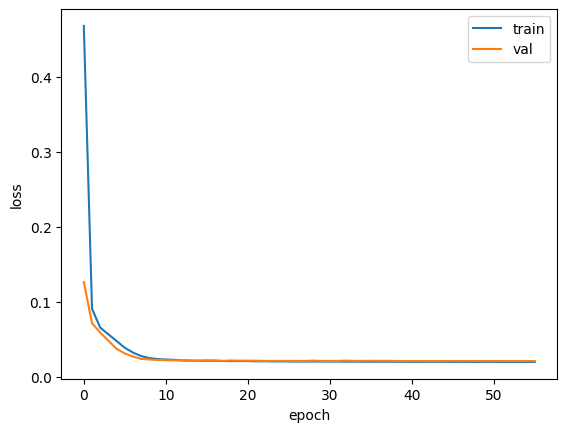

In [ ]:
# AE로 차원축소
import tensorflow.keras as keras
import tensorflow as tf
import time


def AE_feature_extraction(X):
    """
    오토인코더로 차원축소 7 => 4
    학습후에 인코더만 반환
    """
    # 7 => 4
    encoder = keras.models.Sequential([
        keras.layers.Dense(4, activation='relu')
        ]
    )
    # 4 => 7
    decoder = keras.models.Sequential([
        keras.layers.Dense(7, activation=None)
        ]
    )
    # 컴파일 : loss = mse, opt = adam
    AutoEncoder = keras.Sequential([encoder, decoder])
    AutoEncoder.compile(optimizer=keras.optimizers.Adam(0.01),
                        loss='mse')
    
    # 콜백 정의
    # reduce_lr : 학습이 잘 안되면(6 epochs) 학습률 감소
    # e_stop : 특정epoch이상 차도 없으면(12 epochs) 중단
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
    e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=12,
                                              restore_best_weights=True)
    # 학습
    hist = AutoEncoder.fit(X, X,
                           batch_size=32,
                           validation_split=.25,
                           epochs=200,
                           callbacks=[e_stop, reduce_lr],
                           verbose=0)
    
    # 오토인코더 train, val의 epoch별 loss확인
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return encoder

encoder = AE_feature_extraction(X_train.iloc[:,3:])

In [ ]:
X_train2 = np.hstack((X_train.iloc[:,:3], encoder.predict(X_train.iloc[:,3:], verbose=0)))
X_test2 = np.hstack((X_test.iloc[:,:3], encoder.predict(X_test.iloc[:,3:], verbose=0)))

model3 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model3.fit(X_train2, y_train,
           eval_set=[(X_test2, y_test)],
           verbose=False)
''

XGBoostError: [13:57:18] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017f0059f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017f0eb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000017f0e63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000017f1061e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000017f01e86c XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001014ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001014a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x000000010148c140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001014864a4 PyCFuncPtr_call + 228



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_train3 = pca.fit_transform(X_train.iloc[:,3:])
X_test3 = pca.transform(X_test.iloc[:,3:])

X_train3 = np.hstack((X_train.iloc[:,:3], X_train3))
X_test3 = np.hstack((X_test.iloc[:,:3], X_test3))

model4 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model4.fit(X_train3, y_train,
           eval_set=[(X_test3, y_test)],
           verbose=False)
''

XGBoostError: [13:59:23] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017f0059f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017f0eb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000017f0e63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000017f1061e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000017f01e86c XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001014ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001014a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x000000010148c140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001014864a4 PyCFuncPtr_call + 228



In [ ]:
# 혹시 모르니 skewness 조정된 버전도 실험
from scipy.stats import boxcox
from scipy.special import boxcox1p

def data1_prepro_noskew(df1=None):

    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # boxcox로 Sex, Ring제외 skewness 전부 조정
    temp = df1[num_cols].apply(lambda x: x+0.001).apply(lambda x: boxcox(x)[0])
    X = pd.concat([df1[cat_cols], temp], axis=1)
    y = df1.Rings

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')
    
    # test비율 20%로
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=40)
    
    X_train = data1_ct_ohe.fit_transform(X_train)
    X_test = data1_ct_ohe.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train4, X_test4, y_train4, y_test4 = data1_prepro_noskew()

model5 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model5.fit(X_train4, y_train4,
           eval_set=[(X_test4, y_test4)],
           verbose=False)
''

''

In [ ]:
def cv(model, X_train, X_test, y_train, y_test):
    rmse =cross_val_score(model, X_train, y_train,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          fit_params={'eval_set':[(X_test, y_test)],
                                      'verbose':False,})

    rmse = np.sqrt(np.abs(rmse))
    return rmse

ohe_rmse = cv(model, X_train, X_test, y_train, y_test)
ohe_noskew_rmse = cv(model5, X_train4, X_test4, y_train4, y_test4)
te_rmse = cv(model2, X_train_te, X_test_te, y_train_te, y_test_te)
ae_rmse = cv(model3, X_train2, X_test2, y_train, y_test)
pca_rmse = cv(model4, X_train3, X_test3, y_train, y_test)


print(f'ohe cv rmse : {ohe_rmse}')
print(f'ohe cv noskew rmse : {ohe_noskew_rmse}')
print(f'te cv rmse : {te_rmse}')
print(f'ae cv rmse : {ae_rmse}')
print(f'pca cv rmse : {pca_rmse}\n')



print(f'ohe mean rmse : {np.mean(ohe_rmse)}')
print(f'ohe noskew mean rmse : {np.mean(ohe_noskew_rmse)}')
print(f'te mean rmse : {np.mean(te_rmse)}')
print(f'ae mean rmse : {np.mean(ae_rmse)}')
print(f'pca mean rmse : {np.mean(pca_rmse)}')

# xgboost가 공선성에 강하므로 AE, PCA를 통한 feature extraction은 큰 의미는 없는것 같다.
# 마찬가지로 skewness를 없애고 진행해도 결과차이는 크지 않다.


ohe cv rmse : [2.0640369  2.29157908 2.29728733 2.17979154 2.00275552]
ohe cv noskew rmse : [2.19021825 2.2022373  2.21177252 2.15222797 2.219526  ]
te cv rmse : [2.07481908 2.31469053 2.29444519 2.16152719 2.05606906]
ae cv rmse : [2.16315881 2.44069981 2.43922467 2.28064144 2.11798293]
pca cv rmse : [2.13613558 2.42536024 2.32408536 2.27655981 2.10901572]

ohe mean rmse : 2.167090074629537
ohe noskew mean rmse : 2.1951964094506162
te mean rmse : 2.1803102090912247
ae mean rmse : 2.288341532186832
pca mean rmse : 2.2542313412077624


[요인분석] - 실시하였으나, 성능이 좋지 않음.
다만 로딩스코어를 통해 얻은 인사이트 : 성별 제외 모든 컬럼이 한 요인으로 뭉침 = 컴퓨터는 모든 features들을 하나로 인식 = 다중공선성 문제 심강성 재확인

/Users/nayeon/miniforge3/envs/project1/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO값이 0~1 사이가 나오면 요인 분석 진행 가능 : 0.8386574836961511
고유값 : [ 6.92741829e+00  1.51983290e+00  9.11509936e-01  2.77385587e-01
  1.67123401e-01  1.13701949e-01  6.37621738e-02  1.26172680e-02
  6.64849580e-03 -1.59775194e-16]
탐색적요인분석 :                         0         1         2
Length          0.961650  0.005841 -0.000374
Diameter        0.952680  0.013259  0.016636
Height          0.814921  0.028745  0.048432
Whole weight    1.002215 -0.017001 -0.018427
Shucked weight  0.968004 -0.039151 -0.031724
Viscera weight  0.953225  0.001658  0.006379
Shell weight    0.944322  0.005493  0.003989
M               0.008505  0.960320  0.341483
F              -0.016657 -0.198172 -0.983216
I               0.007961 -0.732340  0.624499


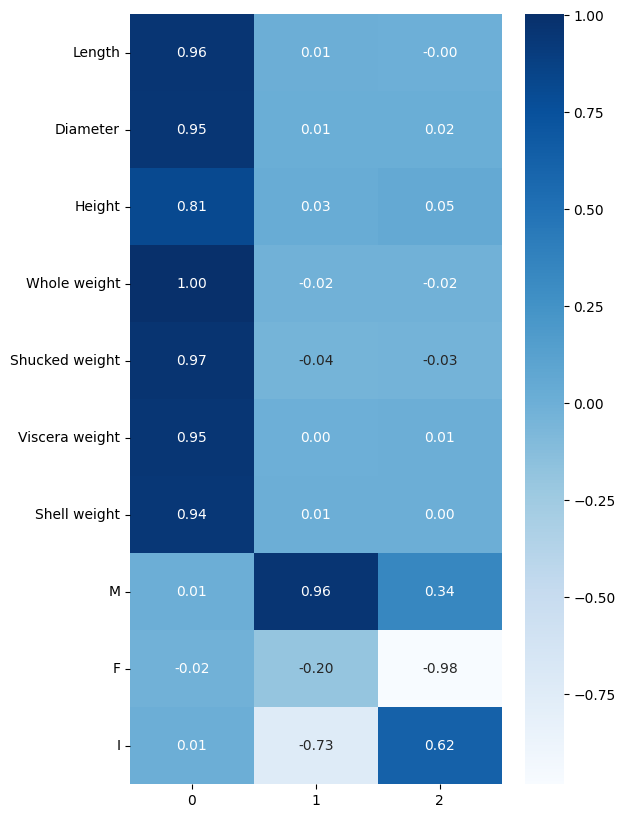

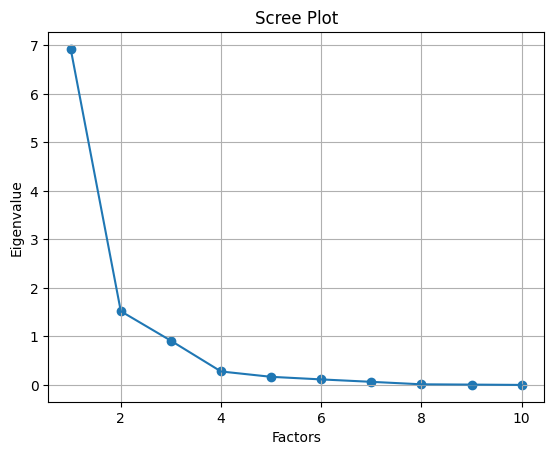

고유값이 1보다 큰 요인은 2개이므로, 특성이 2개의 요인으로 분석될 수 있겠음
          0         1         2
0  6.174869  1.572401  1.502507
1  0.617487  0.157240  0.150251
2  0.617487  0.774727  0.924978


In [35]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import seaborn as sns


#요인 분석 실시

df1 = pd.read_csv('data/Regression_data.csv')


# Apply one-hot encoding to the 'Sex' feature
encoder = OneHotEncoder(sparse_output=False) # !!여기서 drop='first' 인자를 빼야 3개의 원소를 가진 값으로 나옴. / sparse=False : 기본값. 결과를 밀집 형식으로 반환
sex_encoded = encoder.fit_transform(df1[['Sex']])

sex_encoded_df = pd.DataFrame(sex_encoded, columns=['M','F','I']) # columns에 encoder.get_feature_names()값 대신 직접적으로 컬럼명 입력

# Replace the 'Sex' column with the encoded columns
df1 = df1.drop("Sex", axis=1)
df1 = pd.concat([df1, sex_encoded_df], axis=1)
df1_y = df1['Rings']
df1 = df1.drop('Rings', axis=1)

kmo_all,kmo_model=calculate_kmo(df1)

print('KMO값이 0~1 사이가 나오면 요인 분석 진행 가능 :', kmo_model)


# Create factor analysis object and perform factor analysis

fa = FactorAnalyzer()
fa.fit(df1)
eigen_values, vectors = fa.get_eigenvalues()
efa = pd.DataFrame(fa.loadings_, index = df1.columns)

print('고유값 :', eigen_values)
print('탐색적요인분석 : ', efa)
plt.figure(figsize=(6,10))
sns.heatmap(efa, cmap="Blues", annot=True, fmt='.2f')
plt.show()

# Create scree plot using matplotlib

plt.scatter(range(1,df1.shape[1]+1),eigen_values)
plt.plot(range(1,df1.shape[1]+1),eigen_values)

plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

plt.grid()
plt.show()

print('고유값이 1보다 큰 요인은 2개이므로, 특성이 2개의 요인으로 분석될 수 있겠음')


fa = FactorAnalyzer(n_factors=3, rotation='varimax') #최대우도방법

fa.fit(df1)
fa_results = fa.get_factor_variance()
fa_results = pd.DataFrame(fa_results)
print(fa_results)



In [36]:
import statsmodels.api as sm


# 요인 추출한 데이터 생성
factor_scores = fa.transform(df1)
factor_data = pd.DataFrame(factor_scores, columns=['Factor1', 'Factor2', 'Factor3'])



# 선형 회귀 분석 수행
y = df1_y
X = sm.add_constant(factor_data)  # 상수항 추가

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

# 결과 출력
print(model.summary())


# 선형 회귀 모델의 예측값 구하기
y_pred = model.predict(X_train)

# RMSE 값 구하기
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE:", rmse)

#다른 차원축소 방법들보다 못한 결과 도출

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     575.0
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          2.99e-301
Time:                        14:07:19   Log-Likelihood:                -7937.8
No. Observations:                3341   AIC:                         1.588e+04
Df Residuals:                    3337   BIC:                         1.591e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9379      0.045    220.481      0.0

## data1 전처리 요약
* Height 이상치 처리
* Sex 원핫인코딩, 혹은 타겟인코딩
* 수치형 변수 skewness조정시도
* 수치형 변수들 표준화
* 두가지 차원축소 방법 채택 (AE, PCA)
---
결과
* ohe, te, ae, pca 쓴 결과들이 전부 비슷하다.  
* skewness조정한것과 안한것의 차이거의없다.

    => 전처리에서 더 할게 있나??

## data2

[KNN으로 특성공학]

In [47]:
df2 = pd.read_csv('data/binary_classification_data.csv')

X = df2.drop('target_class', axis=1)
y = df2['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.neighbors import KNeighborsClassifier


# KNN 모델 생성 및 훈련
knn = KNeighborsClassifier(n_neighbors=20) #하이퍼파라미터로 조정 필요
knn.fit(X, y)

# 테스트 데이터에 대한 클래스 1에 속할 확률 확인
class_probabilities = knn.predict_proba(X)[:, 1]

# 예측 결과와 클래스 1에 속할 확률 출력

for i, prob_class_1 in enumerate(class_probabilities):
    pred_class = knn.predict(X[i:i+1])[0]
    print(f"Predicted Class: {pred_class}, Class 1 Probability: {prob_class_1}")

result_df = pd.DataFrame({'Class 1 Probability': class_probabilities})

df2_knn = df2

combined_df = pd.concat([df2_knn, result_df], axis=1)
combined_df


Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.05
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.05
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.05
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.5
Predicted Class: 0, Class 1 Probability: 0.0
Predicted Class: 0, Class 1 Probability: 0.0
Predict

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class,Class 1 Probability
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0,0.00
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0,0.00
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0,0.05
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0,0.00
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0,0.05
...,...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0,0.00
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0,0.05
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0,0.05
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0,0.00


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Define a function to train a model and calculate performance metrics
def evaluate_model(model, X_train, y_train, X_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_train, y_pred_train)
    precision = precision_score(y_train, y_pred_train)
    recall = recall_score(y_train, y_pred_train)
    f1 = f1_score(y_train, y_pred_train)
    roc_auc = roc_auc_score(y_train, y_pred_train)
    
    # Return the performance metrics
    return accuracy, precision, recall, f1, roc_auc


# Define the models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(random_state=42,max_depth = 11, criterion="entropy"),
    SVC(),
    GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5),
    MLPClassifier(hidden_layer_sizes = (30, 30, 30), activation='relu', alpha=0.0001)
]

# Define a list to store the results
results = []

# Evaluate each model
for model in models:
    result = evaluate_model(model, X_train, y_train, X_test)
    results.append(result)

# Create a dataframe to store the results
results_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'],
                          index=['Logistic Regression', 'Decision Tree', 'SVM', 'Gradient Boosting', 'Neural Network'])
print('knn 전', results_df)
print('-----------')

X2 = df2_knn.drop('target_class', axis=1)
y2 = df2_knn['target_class']
X_train_knn, X_test_knn, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Define a list to store the results
results2 = []

# Evaluate each model
for model in models:
    result2 = evaluate_model(model, X_train_knn, y_train, X_test_knn)
    results2.append(result2)

# Create a dataframe to store the results
results_df2 = pd.DataFrame(results2, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'],
                          index=['Logistic Regression', 'Decision Tree', 'SVM', 'Gradient Boosting', 'Neural Network'])
print('knn 후', results_df2)


# 전 후에 다른 모델에서는 동일한 값을 보이지만, Gradient Boosting 모델에서는 값이 증가, 신경망에서는 감소

knn 전                      Accuracy  Precision    Recall  F1 Score  ROC AUC Score
Logistic Regression  0.978838   0.941688  0.820941  0.877179       0.907893
Decision Tree        0.993784   0.986540  0.945372  0.965517       0.972032
SVM                  0.972692   0.938505  0.752656  0.835368       0.873828
Gradient Boosting    0.991409   0.986168  0.919575  0.951708       0.959134
Neural Network       0.977162   0.901865  0.843703  0.871815       0.917197
-----------
knn 후                      Accuracy  Precision    Recall  F1 Score  ROC AUC Score
Logistic Regression  0.978838   0.941688  0.820941  0.877179       0.907893
Decision Tree        0.993784   0.986540  0.945372  0.965517       0.972032
SVM                  0.972692   0.938505  0.752656  0.835368       0.873828
Gradient Boosting    0.991898   0.984677  0.926404  0.954652       0.962471
Neural Network       0.977581   0.947085  0.801214  0.868064       0.898338


## data3